### Open File

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('./data/df_features.gz')

I delete the rows without a distance to city center (because in the origin hotel don't have latitude and longitude)

In [3]:
df = df.dropna(subset=['Dist_Center'])

### Create Predicted Category for final models (2 categories)

In [4]:
diff_hotels = df[['Hotel_Address','Diff']].groupby('Hotel_Address').describe()
diff_hotels = diff_hotels.Diff.reset_index()

In [5]:
df = pd.merge(df, diff_hotels, on='Hotel_Address')

In [6]:
category = np.array(['Bad' if i < 7 else 'Good' for i in df.Reviewer_Score])
df.loc[:, 'Category'] = category
df.Category.value_counts() / len(df)

Good    0.831582
Bad     0.168418
Name: Category, dtype: float64

### Balance Nationalities and / or Categories

In [7]:
def balance_df(df, Balance_Nationality, Balance_Category, cut):
    df_balance_country = df.copy()
    if Balance_Nationality:
        df_balance_country = None
        for i in list(df.Nationality_Recode.value_counts().index):
            nationality = df[df.Nationality_Recode == i]
            n = cut
            if len(nationality) < n:
                n = len(nationality)
            nationality = nationality.sample(n, random_state=1)
            df_balance_country = pd.concat([df_balance_country, nationality])
    
    df_balance_class = df_balance_country.copy()
    if Balance_Category:
        df_balance_class = None
        minclass = np.min(df_balance_country.Category.value_counts())
        classes = list(df_balance_country.Category.value_counts().index)
        for i in classes:
            selected_class = df_balance_country[df_balance_country.Category == i].sample(minclass, random_state=1)
            df_balance_class = pd.concat([df_balance_class, selected_class])
    
    return(df_balance_class)

In [8]:
df_balanced_1 = balance_df(df, Balance_Nationality=False, Balance_Category=True, cut=10000)
df_balanced_2 = balance_df(df_balanced_1, Balance_Nationality=True, Balance_Category=True, 
                         cut=int(np.median(df_balanced_1.Nationality_Recode.value_counts())*1.5))
df_balanced_2.shape

(75780, 78)

In [9]:
df_balanced_2.Nationality_Recode.value_counts()

North America          11538
Western Europe         11519
UK & Ireland           11513
Middle east            11477
Eastern Europe          8829
Asia & Pacific          7680
Oceania                 7604
Sub-Saharian Africa     2058
South/Latin America     1610
China                   1099
Arab States              853
Name: Nationality_Recode, dtype: int64

### Prepare Data to run Models

In [10]:
if len(df_balanced_2) > 20000:
    df_model = df_balanced_2.sample(n=20000, random_state=1)
else:
    df_model = df_balanced_2.copy()

df_model.shape

(20000, 78)

In [11]:
x_categorical = ['Review_Month','City','Pet','Purpose','Whom','Room_Recode','Nationality_Recode','Length_Recode','Stars']
x_numerical = ['Average_Score', 'Total_Number_of_Reviews_Reviewer_Has_Given', 'Close_Landmarks', 'Dist_Center', 
               'Dist_Train', 'Dist_Airport','food_Neg_Hotel','staff_Neg_Hotel', 'location_Neg_Hotel', 'value_Neg_Hotel',
               'comfort_Neg_Hotel', 'room_Neg_Hotel', 'facilities_Neg_Hotel','cleanliness_Neg_Hotel', 
               'food_Pos_Hotel', 'staff_Pos_Hotel','location_Pos_Hotel', 'value_Pos_Hotel', 'comfort_Pos_Hotel',
               'room_Pos_Hotel', 'facilities_Pos_Hotel', 'cleanliness_Pos_Hotel','count', 'mean', 'std', 'min', '25%', 
               '50%', '75%', 'max']
x_col = x_categorical + x_numerical
y_col = 'Category'

In [12]:
X_numerical = df_model[x_numerical]
X_numerical_std = X_numerical.apply(lambda x: ((x-np.mean(x)) / np.std(x)))

In [13]:
df_model['Review_Month'] = df_model['Review_Month'].astype(str)
X_categorical = pd.get_dummies(df_model[x_categorical], prefix_sep='_', drop_first=True)
X_categorical = X_categorical.fillna('Not Available')

In [14]:
X = pd.concat([X_numerical_std, X_categorical], axis=1, sort=False)
y = df_model[y_col]

Split into Train and Test

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=1)

In [16]:
X_test.shape, y_test.shape, X_train.shape, y_train.shape

((10000, 76), (10000,), (10000, 76), (10000,))

## MODELS

### Evaluate Model

In [26]:
import time
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, precision_score, recall_score, make_scorer
from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials, space_eval

In [28]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [19]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    clf = model
    clf.fit(X_train, y_train)
    print_result(clf, X_train, X_test, y_train, y_test)
    return(clf.predict(X_test))

In [20]:
def H_score(X_train, y_train):
    acc = accuracy_score(X_train, y_train)
    f1 = f1_score(X_train, y_train, pos_label = "Bad")
    return(2 / ((1/acc)+(1/f1)))

In [22]:
def print_result(clf, X_train, X_test, y_train, y_test):
    print('Accuracy Test :', f'{accuracy_score(clf.predict(X_test), y_test):.4f}', 
          '| F1 Test :', f'{f1_score(clf.predict(X_test), y_test, pos_label="Bad"):.4f}',
          '| Precision Test :', f'{precision_score(clf.predict(X_test), y_test, pos_label="Bad"):.4f}')
    
    print('Accuracy Train:', f'{accuracy_score(clf.predict(X_train), y_train):.4f}', 
          '| F1 Train:', f'{f1_score(clf.predict(X_train), y_train, pos_label="Bad"):.4f}',
          '| Precision Train:', f'{precision_score(clf.predict(X_train), y_train, pos_label="Bad"):.4f}')


In [23]:
def bayesian(space, X, y, modelo, nevals):
    
    H = make_scorer(H_score, greater_is_better=True) 
        
    def objective(space):
        
        global best_score
        
        model = modelo(**space)   
        kfold = KFold(n_splits=5, random_state=1985, shuffle=True)
        score = -cross_val_score(model, X, y, cv=kfold, scoring=H, verbose=False).mean()
        if (score < best_score):
            best_score = score
        return score

    start = time.time()

    best = fmin(
      objective, 
      space = space,
      algo = tpe.suggest, 
      max_evals = nevals,
      trials = Trials())

    print("Hyperopt search took %.2f seconds for 200 candidates" % ((time.time() - start)))
    print("Best score: %.4f " % (-best_score))
    print("Best space: ", space_eval(params, best))
    return(space_eval(params, best))

### KNN

In [24]:
pred_knn = evaluate_model(KNeighborsClassifier(n_neighbors=5), X_train, X_test, y_train, y_test)

Accuracy Test : 0.5991 | F1 Test : 0.5987 | Precision Test : 0.5941
Accuracy Train: 0.7382 | F1 Train: 0.7402 | Precision Train: 0.7410


### Gradient Boosted Trees

In [29]:
params = {'learning_rate':     hp.choice('learning_rate',[0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005 , 0.01, 0.025, 
                                                          0.05, 0.1]), 
          'n_estimators':      hp.choice('n_estimators', [25, 50, 75, 125, 150, 175, 200, 250, 300, 400, 500]),
          'max_depth':         hp.choice('max_depth',[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16]),
          'min_samples_split': hp.choice('min_samples_split',np.linspace(0.01, 1.0, 10, endpoint=True)),
          'min_samples_leaf':  hp.choice('min_samples_leaf',np.linspace(0.01, 0.5, 50, endpoint=True)), 
          'subsample':         hp.choice('subsample',[1]), 
          'max_features':      hp.choice('max_features',['sqrt'])}

best_score = 1
gbt_params = bayesian(params, X_train, y_train, GradientBoostingClassifier, 50)
pred_gbt = evaluate_model(GradientBoostingClassifier(**gbt_params), X_train, X_test, y_train, y_test)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [07:54<00:00,  9.50s/trial, best loss: -0.6673451742883656]
Hyperopt search took 474.92 seconds for 200 candidates
Best score: 0.6673 
Best space:  {'learning_rate': 0.05, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 0.01, 'min_samples_split': 0.12, 'n_estimators': 150, 'subsample': 1}
Accuracy Test : 0.6527 | F1 Test : 0.6593 | Precision Test : 0.6678
Accuracy Train: 0.6996 | F1 Train: 0.7069 | Precision Train: 0.7197


### Random Forest

In [30]:
params = {'bootstrap':         hp.choice('bootstrap',[True, False]),
          'max_depth':         hp.choice('max_depth', range(1, 20)),
          'max_features':      hp.choice('max_features',['auto', 'sqrt']),
          'min_samples_leaf':  hp.choice('min_samples_leaf',np.linspace(0.01, 0.5, 50, endpoint=True)), 
          'min_samples_split': hp.choice('min_samples_split',np.linspace(0.01, 1.0, 100, endpoint=True)), 
          'n_estimators':      hp.choice('n_estimators', [25, 50, 75, 125, 150, 175, 200, 250, 300, 400, 500])}

best_score = 1
rf_params = bayesian(params, X_train, y_train, RandomForestClassifier, 50)
pred_rf = evaluate_model(RandomForestClassifier(**rf_params), X_train, X_test, y_train, y_test)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [05:44<00:00,  6.89s/trial, best loss: -0.6557532754299848]
Hyperopt search took 344.57 seconds for 200 candidates
Best score: 0.6558 
Best space:  {'bootstrap': True, 'max_depth': 1, 'max_features': 'auto', 'min_samples_leaf': 0.09999999999999999, 'min_samples_split': 0.03, 'n_estimators': 25}
Accuracy Test : 0.6443 | F1 Test : 0.6680 | Precision Test : 0.7109
Accuracy Train: 0.6490 | F1 Train: 0.6739 | Precision Train: 0.7203


### XGBoosting

In [31]:
params = {'learning_rate':     hp.choice('learning_rate',[0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005 , 0.01, 0.025, 
                                                          0.05, 0.1]), 
          'max_depth':        hp.choice('max_depth',range(1,20)),
          'min_child_weight': hp.choice('min_child_weight',np.linspace(0.01, 1.0, 100, endpoint=True)),
          'gamma':            hp.choice('gamma',np.linspace(0.01, 1.0, 100, endpoint=True)), 
          'colsample_bytree': hp.choice('colsample_bytree',np.linspace(0.0, 1, 101, endpoint=True)), 
          'n_estimators':     hp.choice('n_estimators', [2, 5, 10, 15, 20, 25, 50, 75])}

best_score = 1
xgb_params = bayesian(params, X_train, y_train, xgb.XGBClassifier, 50)
pred_xgb = evaluate_model(xgb.XGBClassifier(**xgb_params), X_train, X_test, y_train, y_test)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [05:56<00:00,  7.13s/trial, best loss: -0.6652896378794967]
Hyperopt search took 356.82 seconds for 200 candidates
Best score: 0.6653 
Best space:  {'colsample_bytree': 0.44, 'gamma': 0.55, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 0.19, 'n_estimators': 20}
Accuracy Test : 0.6500 | F1 Test : 0.6583 | Precision Test : 0.6698
Accuracy Train: 0.6774 | F1 Train: 0.6885 | Precision Train: 0.7084


### Logistic Regresion

In [32]:
params = {"C":   hp.choice('C',[0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005, 0.01, 0.025, 0.05, 0.1]),
          "tol": hp.choice('tol',[0.00001, 0.000025, 0.00005, 0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005, 0.01, 0.025, 
                                  0.05, 0.1])}

best_score = 1
log_params = bayesian(params, X_train, y_train, LogisticRegression, 50)
pred_log = evaluate_model(LogisticRegression(**log_params), X_train, X_test, y_train, y_test)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:09<00:00,  1.39s/trial, best loss: -0.6633365163147591]
Hyperopt search took 69.44 seconds for 200 candidates
Best score: 0.6633 
Best space:  {'C': 0.01, 'tol': 0.0025}
Accuracy Test : 0.6555 | F1 Test : 0.6566 | Precision Test : 0.6545
Accuracy Train: 0.6670 | F1 Train: 0.6719 | Precision Train: 0.6772


### Decision Trees

In [33]:
iterations = 100
params = {"max_depth":        hp.choice('max_depth', range(1, 20)),
          "max_features":     hp.choice('max_features', range(1, 50)),
          "min_samples_leaf": hp.choice('min_samples_leaf', range(1, 50)),
          "criterion":        hp.choice('criterion', ["gini", "entropy"])}

best_score = 1
tree_params = bayesian(params, X_train, y_train, DecisionTreeClassifier, 150)
pred_tree = evaluate_model(DecisionTreeClassifier(**tree_params), X_train, X_test, y_train, y_test)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [02:01<00:00,  1.23trial/s, best loss: -0.6578514930402085]
Hyperopt search took 121.76 seconds for 200 candidates
Best score: 0.6579 
Best space:  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 44, 'min_samples_leaf': 49}
Accuracy Test : 0.6427 | F1 Test : 0.6697 | Precision Test : 0.7198
Accuracy Train: 0.6562 | F1 Train: 0.6841 | Precision Train: 0.7396


### SVM

In [34]:
params = {"degree": hp.choice('degree', [2, 3, 4]),
          "kernel": hp.choice('kernel', ['poly']), 
          "C":      hp.choice('C', [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075, 
                                    0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75])}
best_score = 1
svm_params = bayesian(params, X_train, y_train, SVC, 10)
pred_svm = evaluate_model(SVC(**svm_params), X_train, X_test, y_train, y_test)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [15:30<00:00, 93.02s/trial, best loss: -0.6639890021486339]
Hyperopt search took 930.19 seconds for 200 candidates
Best score: 0.6640 
Best space:  {'C': 0.05, 'degree': 3, 'kernel': 'poly'}
Accuracy Test : 0.6369 | F1 Test : 0.6746 | Precision Test : 0.7477
Accuracy Train: 0.6577 | F1 Train: 0.6958 | Precision Train: 0.7775


### Naive Bayes

In [35]:
params = {"alpha":     hp.choice('alpha', [0.025, 0.05, 0.075, 0.1, 0.15, 0.20, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 
                                           2, 2.5, 5, 10]), 
          "fit_prior": hp.choice('fit_prior', [True, False])}

best_score = 1
nb_params = bayesian(params, X_train, y_train, BernoulliNB, 50)
pred_nb = evaluate_model(BernoulliNB(**nb_params), X_train, X_test, y_train, y_test)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:28<00:00,  1.78s/trial, best loss: -0.644064389331181]
Hyperopt search took 88.90 seconds for 200 candidates
Best score: 0.6441 
Best space:  {'alpha': 0.75, 'fit_prior': True}
Accuracy Test : 0.6465 | F1 Test : 0.6391 | Precision Test : 0.6219
Accuracy Train: 0.6457 | F1 Train: 0.6417 | Precision Train: 0.6301


## STACKING

Predictions using Random Forest adding the predicions of other models to the original dataset.
I had to split the test set in 2 to create the new train/test set, otherwise i fall into overfitting because my original training set is biased vs the test set

First I append the predictions of the model to the dataset

In [36]:
X_2 = X_test.copy()
y_2 = y_test.copy()

In [37]:
X_2['logistic'] = pred_log
X_2['gbt'] = pred_gbt
X_2['knn'] = pred_knn
X_2['svm'] = pred_svm
X_2['tree'] = pred_tree
X_2['xgb'] = pred_xgb
X_2['nb'] = pred_nb
X_2['rf'] = pred_rf

In [38]:
X_2.iloc[:,-8:].head(2)

,logistic,gbt,knn,svm,tree,xgb,nb,rf
333373,Bad,Bad,Bad,Bad,Bad,Bad,Bad,Bad
127076,Bad,Bad,Bad,Bad,Bad,Bad,Bad,Bad


In [39]:
X_2.iloc[:,-8:] = X_2.iloc[:,-8:].apply(lambda x: [1 if i=='Good' else 0 for i in x])

In [40]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=100)

### Gradient Boosting Trees

In [41]:
params = {'learning_rate':     hp.choice('learning_rate',[0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005 , 0.01, 0.025, 
                                                          0.05, 0.1]), 
          'n_estimators':      hp.choice('n_estimators', [25, 50, 75, 125, 150, 175, 200, 250, 300, 400, 500]),
          'max_depth':         hp.choice('max_depth',[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16]),
          'min_samples_split': hp.choice('min_samples_split',np.linspace(0.01, 1.0, 10, endpoint=True)),
          'min_samples_leaf':  hp.choice('min_samples_leaf',np.linspace(0.01, 0.5, 50, endpoint=True)), 
          'subsample':         hp.choice('subsample',[1]), 
          'max_features':      hp.choice('max_features',['sqrt'])}

best_score = 1
gbt_params = bayesian(params, X_train_2, y_train_2, GradientBoostingClassifier, 50)
pred_gbt_stck = evaluate_model(GradientBoostingClassifier(**gbt_params), X_train_2, X_test_2, y_train_2, y_test_2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [07:40<00:00,  9.21s/trial, best loss: -0.6690185829609094]
Hyperopt search took 460.72 seconds for 200 candidates
Best score: 0.6690 
Best space:  {'learning_rate': 0.001, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 0.05, 'min_samples_split': 0.45, 'n_estimators': 175, 'subsample': 1}
Accuracy Test : 0.6495 | F1 Test : 0.6692 | Precision Test : 0.7309
Accuracy Train: 0.6536 | F1 Train: 0.6799 | Precision Train: 0.7243


### XGB

In [42]:
params = {'learning_rate':    hp.choice('learning_rate',[0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005 , 0.01, 0.025, 
                                                         0.05, 0.1]), 
          'max_depth':        hp.choice('max_depth',range(1,20)),
          'min_child_weight': hp.choice('min_child_weight',np.linspace(0.01, 1.0, 100, endpoint=True)),
          'gamma':            hp.choice('gamma',np.linspace(0.01, 1.0, 100, endpoint=True)), 
          'colsample_bytree': hp.choice('colsample_bytree',np.linspace(0.0, 1, 101, endpoint=True)), 
          'n_estimators':     hp.choice('n_estimators', [2, 5, 10, 15, 20, 25, 50, 75])}

best_score = 1
xgb_params = bayesian(params, X_train_2, y_train_2, xgb.XGBClassifier, 50)
pred_xgb_stck = evaluate_model(xgb.XGBClassifier(**xgb_params), X_train_2, X_test_2, y_train_2, y_test_2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [12:48<00:00, 15.37s/trial, best loss: -0.6630783740403652]
Hyperopt search took 769.11 seconds for 200 candidates
Best score: 0.6631 
Best space:  {'colsample_bytree': 0.03, 'gamma': 0.55, 'learning_rate': 0.00025, 'max_depth': 3, 'min_child_weight': 0.03, 'n_estimators': 75}
Accuracy Test : 0.6545 | F1 Test : 0.6654 | Precision Test : 0.7082
Accuracy Train: 0.6589 | F1 Train: 0.6757 | Precision Train: 0.6997


### SVM

In [43]:
params = {"degree": hp.choice('degree', [2, 3, 4]),
          "kernel": hp.choice('kernel', ['poly']), 
          "C":      hp.choice('C', [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075, 
                                    0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75])}
best_score = 1
svm_params = bayesian(params, X_train_2, y_train_2, SVC, 10)
pred_svm_stck = evaluate_model(SVC(**svm_params), X_train_2, X_test_2, y_train_2, y_test_2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [09:57<00:00, 59.79s/trial, best loss: -0.6696341628674858]
Hyperopt search took 597.93 seconds for 200 candidates
Best score: 0.6696 
Best space:  {'C': 0.05, 'degree': 2, 'kernel': 'poly'}
Accuracy Test : 0.6465 | F1 Test : 0.6734 | Precision Test : 0.7515
Accuracy Train: 0.6567 | F1 Train: 0.6897 | Precision Train: 0.7512


### Logistic Regression

In [44]:
params = {"C":   hp.choice('C',[0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005, 0.01, 0.025, 0.05, 0.1]),
          "tol": hp.choice('tol',[0.00001, 0.000025, 0.00005, 0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005, 0.01, 0.025, 
                                  0.05, 0.1])}

best_score = 1
log_params = bayesian(params, X_train_2, y_train_2, LogisticRegression, 50)
pred_log_stck = evaluate_model(LogisticRegression(**log_params), X_train_2, X_test_2, y_train_2, y_test_2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:55<00:00,  1.12s/trial, best loss: -0.6593705492884631]
Hyperopt search took 55.82 seconds for 200 candidates
Best score: 0.6594 
Best space:  {'C': 0.0025, 'tol': 0.05}
Accuracy Test : 0.6620 | F1 Test : 0.6620 | Precision Test : 0.6825
Accuracy Train: 0.6573 | F1 Train: 0.6659 | Precision Train: 0.6727


### Decision Trees

In [45]:
iterations = 100
params = {"max_depth":        hp.choice('max_depth', range(1, 20)),
          "max_features":     hp.choice('max_features', range(1, 50)),
          "min_samples_leaf": hp.choice('min_samples_leaf', range(1, 50)),
          "criterion":        hp.choice('criterion', ["gini", "entropy"])}

best_score = 1
tree_params = bayesian(params, X_train_2, y_train_2, DecisionTreeClassifier, 150)
pred_tree_stck = evaluate_model(DecisionTreeClassifier(**tree_params), X_train_2, X_test_2, y_train_2, y_test_2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:45<00:00,  1.42trial/s, best loss: -0.6652384950981534]
Hyperopt search took 105.85 seconds for 200 candidates
Best score: 0.6652 
Best space:  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 47, 'min_samples_leaf': 29}
Accuracy Test : 0.6490 | F1 Test : 0.6562 | Precision Test : 0.6907
Accuracy Train: 0.6580 | F1 Train: 0.6704 | Precision Train: 0.6847


In [46]:
pd.crosstab(pred_svm_stck, y_test_2)

Category,Bad,Good
row_0,,
Bad,729,466
Good,241,564


## BACKWARD ELIMINATION

In [49]:
import random
from random import sample

In [57]:
def try_seed(seed, verbose=True):
    score = check_model('', X_train_2, X_test_2, y_train_2, y_test_2)[1]
    varout = []
    varin = list(X_test_2.columns)

    for n in range(len(varin)):
        max_score = score
        max_feature = []
        random.seed(seed)
        
        for i in sample(varin, len(varin)):
            var_test = varin.copy()
            var_test.remove(i)
            X_train_vartest = X_train_2[var_test]
            X_test_vartest = X_test_2[var_test]
            check = check_model(i, X_train_vartest, X_test_vartest, y_train_2, y_test_2)
            if check[1] > max_score:
                max_feature = check[0]
                max_score = check[1] 
                varin.remove(max_feature)   
                varout.append(max_feature)
                if verbose:
                    print('{0:0=2d}'.format(n), 'Original Score:', f'{score:.4f}', '| New score:', f'{max_score:.4f}', 
                          end='\r', flush=True)
                break

        if max_score > score:
            score = max_score
        else:
            print('Seed:',seed, '<-', f'{score:.4f}','                                                                       ')
            return(varin, score)
            break

### Gradient Boosting

In [55]:
best = {'learning_rate': 0.001, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 0.05, 
        'min_samples_split': 0.45, 'n_estimators': 175, 'subsample': 1}
    
def check_model(variable, X_train, X_test, y_train, y_test):
    clf = GradientBoostingClassifier(**best, random_state=1)            
    clf.fit(X_train, y_train)
    score = H_score(clf.predict(X_train), y_train)
    return(variable, score)

In [56]:
max_score = 0
var_selec = []
for seed in range(4):
    varin, score = try_seed(seed, verbose=True)
    if score > max_score:
        max_score = score
        var_selec = varin

Seed: 0 <- 0.6692: 0.6687 | New score: 0.6692 | Variable to remove: Dist_Airportrs with friends
Seed: 1 <- 0.6691: 0.6672 | New score: 0.6691 | Variable to remove: value_Pos_Hoteltayed 8 nights
Seed: 2 <- 0.6694: 0.6685 | New score: 0.6694 | Variable to remove: location_Neg_Hotelel
Seed: 3 <- 0.6696: 0.6687 | New score: 0.6696 | Variable to remove: location_Pos_Hotel


In [61]:
X_train_varin = X_train_2[var_selec]
X_test_varin = X_test_2[var_selec] 

X_train_varin = X_train_2
X_test_varin = X_test_2

clf = GradientBoostingClassifier(**best, random_state=1)
clf.fit(X_train_varin, y_train_2)
print("F1-Score: ", f1_score(clf.predict(X_test_varin), y_test_2, pos_label='Bad'))
print("Accuracy: ", accuracy_score(clf.predict(X_test_varin), y_test_2))
print("Recall:   ", recall_score(clf.predict(X_test_varin), y_test_2, pos_label='Bad'))
print("Precision:", precision_score(clf.predict(X_test_varin), y_test_2, pos_label='Bad'))
print("H-Score  :", H_score(clf.predict(X_test_varin), y_test_2))

F1-Score:  0.6701176470588235
Accuracy:  0.6495
Recall:    0.6164502164502165
Precision: 0.734020618556701
H-Score  : 0.6596477589319545


In [62]:
pd.crosstab(clf.predict(X_test_varin), y_test_2)

Category,Bad,Good
row_0,,
Bad,712,443
Good,258,587


## CONFIDENCE INTERVAL

In [68]:
pred_f1 = []
pred_ac = []
pred_H = []

for i in range(10000):
    sample = np.random.randint(0, len(X_test_varin), size=len(X_test_varin))
    X_sample = X_test_varin.iloc[sample]
    y_sample = y_test_2.iloc[sample]
    print(i, end='\r', flush=True)
    pred_f1.append(f1_score(clf.predict(X_sample), y_sample, pos_label='Bad'))
    pred_ac.append(accuracy_score(clf.predict(X_sample), y_sample))
    pred_H.append(H_score(clf.predict(X_sample), y_sample))

(array([   6.,   10.,   29.,   38.,   89.,  153.,  271.,  385.,  572.,
         757.,  920., 1056., 1090., 1129.,  963.,  822.,  590.,  452.,
         311.,  182.,   86.,   53.,   21.,   12.,    3.]),
 array([0.62120884, 0.62425561, 0.62730238, 0.63034914, 0.63339591,
        0.63644268, 0.63948944, 0.64253621, 0.64558298, 0.64862974,
        0.65167651, 0.65472328, 0.65777004, 0.66081681, 0.66386358,
        0.66691034, 0.66995711, 0.67300388, 0.67605064, 0.67909741,
        0.68214418, 0.68519094, 0.68823771, 0.69128447, 0.69433124,
        0.69737801]),
 <a list of 25 Patch objects>)

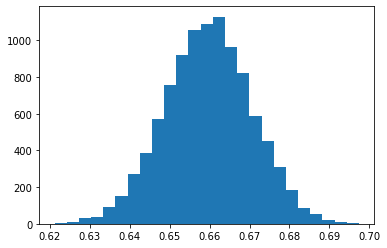

In [72]:
plt.hist(pred_H, bins=25)

In [83]:
print('            2.5%    50%  97.5%')
print('H-Score: ',f'{np.percentile(pred_H, 2.5):.4f}',f'{np.percentile(pred_H, 50):.4f}',f'{np.percentile(pred_H, 97.5):.4f}')
print('Accuracy:',f'{np.percentile(pred_ac,2.5):.4f}',f'{np.percentile(pred_ac,50):.4f}',f'{np.percentile(pred_ac,97.5):.4f}')
print('F1-Score:',f'{np.percentile(pred_f1,2.5):.4f}',f'{np.percentile(pred_f1,50):.4f}',f'{np.percentile(pred_f1,97.5):.4f}')

            2.5%    50%  97.5%
H-Score:  0.6382 0.6598 0.6805
Accuracy: 0.6285 0.6495 0.6705
F1-Score: 0.6468 0.6701 0.6927
